In [55]:
# TASK OVERVIEW
# Read csv file
# Become familiar with data using visualizations and DataFrame methods
# Encode categorical features, complete data, and apply scaling
# Define X and y variables
# Split into training and testing data
# Look into types of classification models
# Use K-fold cross validation on multiple to determine best
# Improve accuracy of best model using training data
# Analyze on testing data


In [56]:
# Read csv file

import numpy as np
import pandas as pd
import sklearn as sk

file_data = pd.read_csv('credit_data.csv')

# Drops unnecessary first column containing original row numbers
credit_data = file_data.drop('Unnamed: 0', axis=1)

# Shows first five rows of data from file
credit_data.head()


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [57]:
# Become familiar with data set: shape, values

shape = credit_data.shape
print('credit_data shape:', shape)

# Returns number of unique values for each feature
print()
print('num unique:')
print(credit_data.nunique())

# Looks specifically at Saving account feature
# print()
# print(credit_data['Saving accounts'].unique())
# print(credit_data.groupby('Saving accounts').size())

# Looks specifically at Checking account feature
# print()
# print(credit_data['Checking account'].unique())
# print(credit_data.groupby('Checking account').size())

# Looks specifically at Risk
print()
print(credit_data['Risk'].unique())
print(credit_data.groupby('Risk').size())


credit_data shape: (1000, 10)

num unique:
Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       4
Checking account      3
Credit amount       921
Duration             33
Purpose               8
Risk                  2
dtype: int64

['good' 'bad']
Risk
bad     300
good    700
dtype: int64


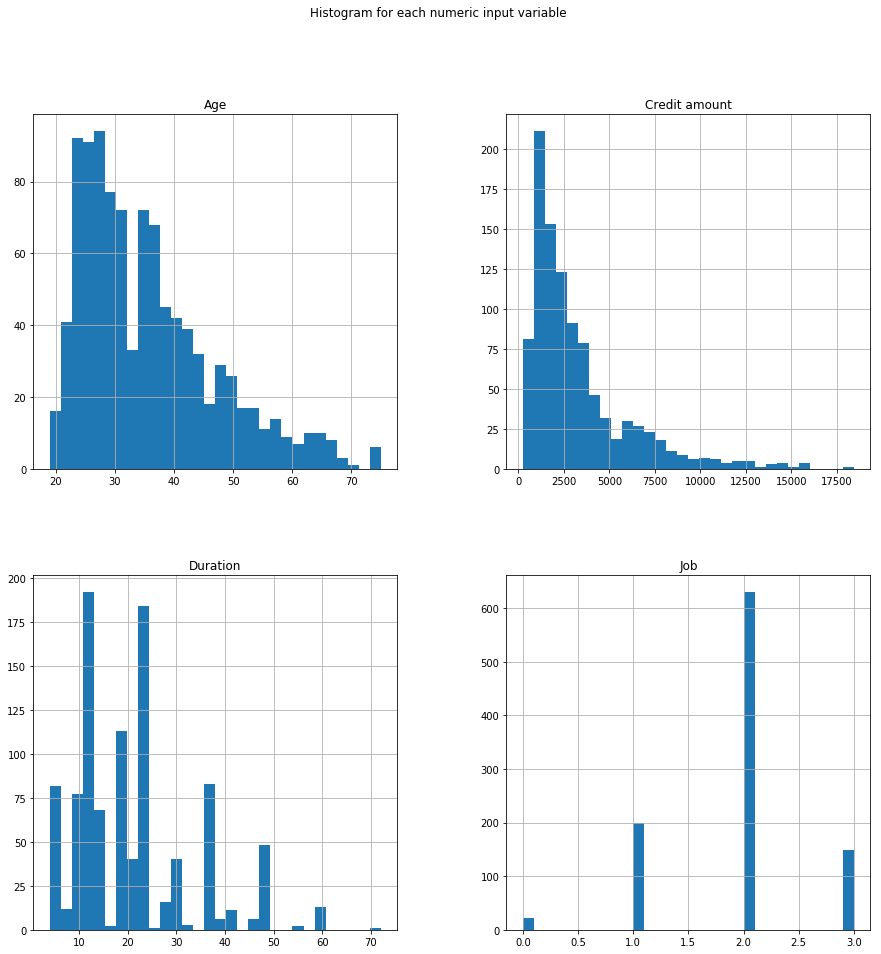

In [58]:
# Plots only numerical valued data to find correlation: Age, Job, Credit amount, Duration

import pylab as pl
import matplotlib.pyplot as plt

# pandas.DataFrame.drop drops either a row or column, specify with axis
# pandas.DataFrame.hist bins parameter specifies number of groups to divide data into, default is 10
credit_data.drop(['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'Risk'],axis=1).hist(bins=30, figsize=(15,15))
pl.suptitle("Histogram for each numeric input variable")
plt.savefig('num_hist')
plt.show()

# QUICK OBSERVATIONS
# Slightly strong correlation between Age and Credit amount
# Weaker correlation with Duration in months
# Cannot form correlation with number of Jobs
# Data from rich correlate to good credit and own housing
# Not enough to help significantly


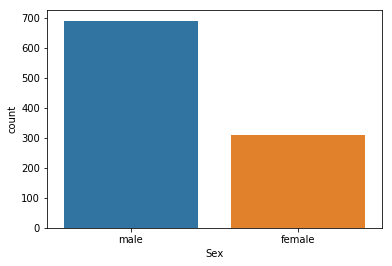

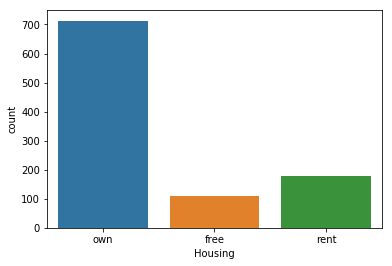

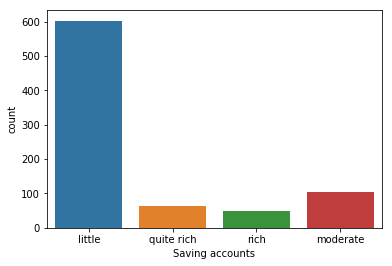

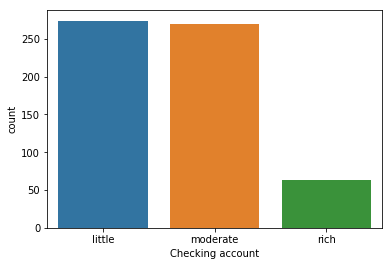

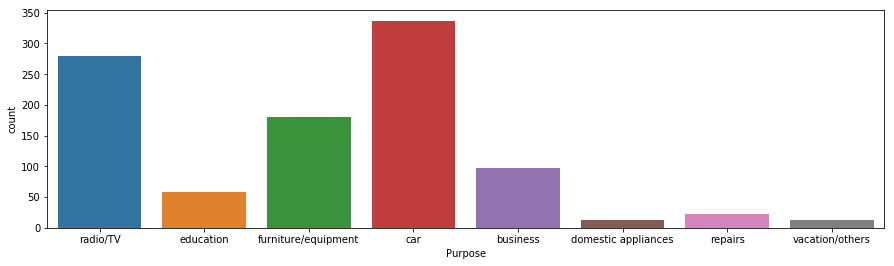

In [59]:
# Plots non-numerical valued data to find correlation: 'Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose'

# seaborn is a data visualization library in Python
import seaborn as sns

sns.countplot(credit_data['Sex'], label="Count")
plt.show()

sns.countplot(credit_data['Housing'], label="Count")
plt.show()

sns.countplot(credit_data['Saving accounts'], label="Count")
plt.show()

sns.countplot(credit_data['Checking account'], label="Count")
plt.show()

plt.figure(figsize=(15,4))
sns.countplot(credit_data['Purpose'], label="Count")
plt.show()


In [60]:
# Divide customers from data into categories based on age to provide more relevant information
# Separate by most likely university age, younger adult, older adult, or retired/senior

interval = (18, 25, 40, 65, 100)

categories = ['University', 'Younger', 'Older', 'Senior']
credit_data["Age_by_Category"] = pd.cut(credit_data.Age, interval, labels=categories)

# Determine which examples are good or bad for future reference
credit_good = credit_data[credit_data["Risk"] == 'good']
credit_bad = credit_data[credit_data["Risk"] == 'bad']

credit_data.head()


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,Age_by_Category
0,67,male,2,own,NaN,little,1169,6,radio/TV,good,Senior
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad,University
2,49,male,1,own,little,NaN,2096,12,education,good,Older
3,45,male,2,free,little,little,7882,42,furniture/equipment,good,Older
4,53,male,2,free,little,little,4870,24,car,bad,Older


In [61]:
# Unique values for each feature

print("Age: ", credit_data['Age'].unique())
print("Purpose: ", credit_data['Purpose'].unique())
print("Sex: ", credit_data['Sex'].unique())
print("Housing: ", credit_data['Housing'].unique())
print("Saving accounts: ", credit_data['Saving accounts'].unique())
print("Risk: ", credit_data['Risk'].unique())
print("Checking account: ", credit_data['Checking account'].unique())
print("Age_by_Category: ", credit_data['Age_by_Category'].unique())


Age:  [67 22 49 45 53 35 61 28 25 24 60 32 44 31 48 26 36 39 42 34 63 27 30 57
 33 37 58 23 29 52 50 46 51 41 40 66 47 56 54 20 21 38 70 65 74 68 43 55
 64 75 19 62 59]
Purpose:  ['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']
Sex:  ['male' 'female']
Housing:  ['own' 'free' 'rent']
Saving accounts:  [nan 'little' 'quite rich' 'rich' 'moderate']
Risk:  ['good' 'bad']
Checking account:  ['little' 'moderate' nan 'rich']
Age_by_Category:  [Senior, University, Older, Younger]
Categories (4, object): [University < Younger < Older < Senior]


In [62]:
# One hot and dummy encoding

def one_hot(df, nan = False):
    original = list(df.columns)
    category = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns = category, dummy_na = nan, drop_first = True)
    new_columns = [c for c in df.columns if c not in original]
    return df, new_columns

credit_data['Saving accounts'] = credit_data['Saving accounts'].fillna('no_data')
credit_data['Checking account'] = credit_data['Checking account'].fillna('no_data')


# Create dummy variables, contain 0 or 1 as a result of one hot encoding depending on whether value is True
# Difference between one hot and dummy is that dummy drops one of the values for k-1 instead of k variables
credit_data = credit_data.merge(pd.get_dummies(credit_data['Purpose'], drop_first=True, prefix='Purpose'), left_index=True, right_index=True)
credit_data = credit_data.merge(pd.get_dummies(credit_data['Sex'], drop_first=True, prefix='Sex'), left_index=True, right_index=True)
credit_data = credit_data.merge(pd.get_dummies(credit_data['Housing'], drop_first=True, prefix='Housing'), left_index=True, right_index=True)
credit_data = credit_data.merge(pd.get_dummies(credit_data["Saving accounts"], drop_first=True, prefix='Savings'), left_index=True, right_index=True)
credit_data = credit_data.merge(pd.get_dummies(credit_data.Risk, prefix='Risk'), left_index=True, right_index=True)
credit_data = credit_data.merge(pd.get_dummies(credit_data["Checking account"], drop_first=True, prefix='Checking'), left_index=True, right_index=True)
credit_data = credit_data.merge(pd.get_dummies(credit_data["Age_by_Category"], drop_first=True, prefix='Age_by_Category'), left_index=True, right_index=True)

credit_data.head()


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,...,Savings_quite rich,Savings_rich,Risk_bad,Risk_good,Checking_moderate,Checking_no_data,Checking_rich,Age_by_Category_Younger,Age_by_Category_Older,Age_by_Category_Senior
0,67,male,2,own,no_data,little,1169,6,radio/TV,good,...,0,0,0,1,0,0,0,0,0,1
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad,...,0,0,1,0,1,0,0,0,0,0
2,49,male,1,own,little,no_data,2096,12,education,good,...,0,0,0,1,0,1,0,0,1,0
3,45,male,2,free,little,little,7882,42,furniture/equipment,good,...,0,0,0,1,0,0,0,0,1,0
4,53,male,2,free,little,little,4870,24,car,bad,...,0,0,1,0,0,0,0,0,1,0


In [63]:
# Delete these data columns for models and use certain one-hot values instead

del credit_data["Saving accounts"]
del credit_data["Checking account"]
del credit_data["Purpose"]
del credit_data["Sex"]
del credit_data["Housing"]
del credit_data["Age_by_Category"]
del credit_data["Risk"]
del credit_data['Risk_good']


In [64]:
# Scale credit amount by natural log function to smaller values

credit_data['Credit amount'] = np.log(credit_data['Credit amount'])
credit_data.head()


,Age,Job,Credit amount,Duration,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,...,Savings_no_data,Savings_quite rich,Savings_rich,Risk_bad,Checking_moderate,Checking_no_data,Checking_rich,Age_by_Category_Younger,Age_by_Category_Older,Age_by_Category_Senior
0,67,2,7.063904,6,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
1,22,2,8.691315,48,0,0,0,0,1,0,...,0,0,0,1,1,0,0,0,0,0
2,49,1,7.647786,12,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
3,45,2,8.972337,42,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,53,2,8.490849,24,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [65]:
# Import preprocessing tools to evaluate models
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score
from sklearn.model_selection import GridSearchCV

# Algorithm models to use
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier


In [66]:
# Define X and y variables, use bad risk examples as y

X = credit_data.drop('Risk_bad', axis = 1).values
y = credit_data["Risk_bad"].values

print('X:', X)
print('y:', y)


X: [[67.          2.          7.06390396 ...  0.          0.
   1.        ]
 [22.          2.          8.69131455 ...  0.          0.
   0.        ]
 [49.          1.          7.64778605 ...  0.          1.
   0.        ]
 ...
 [38.          2.          6.68959927 ...  1.          0.
   0.        ]
 [23.          2.          7.52023456 ...  0.          0.
   0.        ]
 [27.          2.          8.42858053 ...  1.          0.
   0.        ]]
y: [0 1 0 0 1 0 0 0 0 1 1 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0
 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0
 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0
 0 0 1 0 0 1 0 1 0 1 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 1 1 0 0 0 0 1 1 1 0 1
 0 1 0 1 0 1 1 1 0 1 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 0 1 0 0 0 0 1 1 1 0 0 1 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0
 0 0 0 0 0 0 1 0 0 1 0 0 

In [67]:
# Split into training and testing data
from sklearn.model_selection import train_test_split, KFold, cross_val_score

# 80-20 data split between training and testing, set randomness
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)
seed = 5

print('X_train:', X_train)
print('y_train:', y_train)

print()

print('X_test:', X_test)
print('y_test:', y_test)


X_train: [[25.          2.          7.15695636 ...  0.          0.
   0.        ]
 [50.          2.          7.77904864 ...  0.          1.
   0.        ]
 [28.          3.          7.98036577 ...  1.          0.
   0.        ]
 ...
 [46.          1.          8.18702107 ...  0.          1.
   0.        ]
 [30.          3.          7.50823877 ...  1.          0.
   0.        ]
 [37.          2.          7.64969262 ...  1.          0.
   0.        ]]
y_train: [0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 0 1 0 0 0
 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0
 1 0 0 0 0 0 1 0 1 0 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 1 1 1 0 0 0 0 0 1 0 1 0 0 1 1 0 1 1 0 0 0 1 1 0 1 0 0 0 0 0 1 1
 0 1 0 1 0 0 1 0 0 1 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0
 0 0 0 1 0 0 0 0 1 0 1 0 0 0 1 1 1 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 1 1 

In [68]:
# Choose models and add to array

models = []

model1 = ('LR', LogisticRegression())  # Logistical regression
model2 = ('NB', GaussianNB())  # Naive Bayes
model3 = ('RF', RandomForestClassifier())  # Random Forest
model4 = ('SVM', SVC())  # Support Vector Machine
model5 = ('DT', DecisionTreeClassifier())  # Decision Tree
model6 = ('KN', KNeighborsClassifier())  # K Neighbors
model7 = ('MLP', MLPClassifier())  # Multi-Layer Perceptron

models.append(model1)
models.append(model2)
models.append(model3)
models.append(model4)
models.append(model5)
models.append(model6)
models.append(model7)


In [69]:
# Check models to find best using 10-fold Cross Validation method

results = []
names = []

for name, model in models:
        kfold = KFold(n_splits=20, random_state=seed)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring = 'recall')
        results.append(cv_results)
        names.append(name)
        print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))

#   RESULTS with 20 splits
# Logistic Regression:
#  Mean = 0.33; Std Dev = 0.14
# Naive Bayes:
#  Mean = 0.54; Std Dev = 0.14
# Random Forest:
#  Mean = 0.37; Std Dev = 0.11
# Support Vector:
#  Mean = 0.10; Std Dev = 0.08
# Decision Tree:
#  Mean = 0.41; Std Dev = 0.14
# K Neighbors:
#  Mean = 0.25; Std Dev = 0.14
# MLP Classifier:
#  Mean = 0.41; Std Dev = 0.16

#   ANALYSIS
# Naive Bayes has highest average of 0.54 from cross validation
# Next best are MLP, DT, LR, RF, KN, and SVM in order


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

LR: 0.332643 (0.135952)
NB: 0.541001 (0.135856)


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/nbuser/anaconda3_501/l

RF: 0.296294 (0.127131)


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/nbuser/anaconda3_501/lib/python3.6/si

SVM: 0.101756 (0.079353)
DT: 0.439491 (0.119404)
KN: 0.251917 (0.142462)


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization h

MLP: 0.397253 (0.140816)


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [70]:
# MODEL: Gaussian Naive Bayes

# Create a Gaussian classifier
model = GaussianNB()

# Train model using training data
trained_model_nb = model.fit(X_train, y_train)


# Predict output using training data
y_pred_train_nb = trained_model_nb.predict(X_train)

print('y pred train: ', y_pred_train_nb)
print('y actual train: ', y_train)

# Determine number of errors from training data
print("Number of mislabeled points out of a total %d points for training set: %d" % (X_train.shape[0],(y_train != y_pred_train_nb).sum()))
# RESULT: 233 out of 800 points are mislabeled


y pred train:  [0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 1 0 1 1 1 0 1 0 1 0 0 0 1 0 0
 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0
 1 0 1 0 0 1 1 1 1 1 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 1 1 0 0 0
 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0
 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 0 0 0 1 0 1 1 0 1 0 0 0 0 0
 1 1 0 1 0 0 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 1 1 0 0 1 1 0 1 1 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0
 0 0 0 0 1 1 1 0 0 1 0 0 1 1 0 1 1 0 0 0 0 1 1 0 0 0 0 0 1 0 1 0 1 1 1 0 0
 1 0 0 0 1 0 0 0 1 0 0 1 1 1 1 1 1 0 1 0 0 0 0 1 1 0 0 1 0 1 1 0 0 0 0 1 0
 0 0 1 0 0 0 0 1 0 1 1 0 0 1 0 1 1 0 1 0 1 0 0 1 0 0 1 0 0 0 0 1 1 0 1 1 0
 0 1 1 0 1 0 1 0 1 0 0 1 0 1 1 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 1
 1 0 0 1 0 1 1 1 0 0 0 1 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 0 0 0 1 1 1 0
 0 1 1 1 1 0 1 0 1 0 1 0 1 0 1 0 0 0 1 1 0 1 1 0 0 0 1 1 1 0 0 1 0 1 0 1 0
 0 0 1 0 0

In [71]:
# Run previous cell before this cell

# Predict output using training data
y_pred_test_nb = trained_model_nb.predict(X_test)
print('y pred test: ', y_pred_test_nb)
print('y actual test: ', y_test)

# Determine number of errors from training data
print("Number of mislabeled points out of a total %d points for testing set: %d" % (X_test.shape[0],(y_test != y_pred_test_nb).sum()))
# RESULT: 52 out of 200 points are mislabeled


y pred test:  [1 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 1 0
 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 1 1 1 0 1 1 0 0 0 0 1 0 1 1 0 1 1 0 0 0 0 1
 1 1 1 0 1 0 1 0 0 0 1 0 1 0 1 0 0 1 1 0 0 0 1 1 0 1 1 0 1 1 0 0 0 1 0 1 0
 0 1 1 0 0 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0
 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1
 0 0 0 0 1 1 1 0 0 0 0 0 1 0 1]
y actual test:  [1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 1 1 0 0 0 0 0 1 0
 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0
 1 0 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 1 1 1 0 0 0 0 1 1 0 0
 0 0 1 0 1 1 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0
 1 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0 1 1 0 1 0 0 0 0 0 1 0 1
 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0]
Number of mislabeled points out of a total 200 points for testing set: 52


In [72]:
# Train and testing accuracies

print('Train Accuracy: ', accuracy_score(y_train, y_pred_train_nb))  # 0.70875
print('Test Accuracy: ', accuracy_score(y_test, y_pred_test_nb))  # 0.74


Train Accuracy:  0.70875
Test Accuracy:  0.74


Text(91.68, 0.5, 'Predicted')

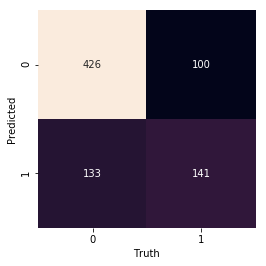

In [73]:
# Confusion matrix of trained model on training set

matrix = confusion_matrix(y_pred_train_nb, y_train)
values = np.unique(y_pred_train_nb)

sns.heatmap(matrix, square=True, annot=True, fmt='d', cbar=False, xticklabels=values, yticklabels=values)
plt.xlabel('Truth')
plt.ylabel('Predicted')

# RESULTS
# 567 are correct, 133 of Type 1 error (false positive), 100 of Type 2 error (false negative)


Text(91.68, 0.5, 'Predicted')

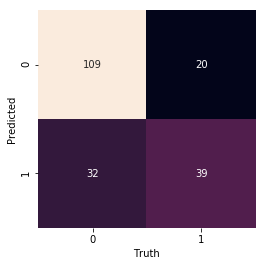

In [74]:
# Confusion matrix of trained model on testing set

matrix = confusion_matrix(y_pred_test_nb, y_test)
values = np.unique(y_pred_test_nb)

sns.heatmap(matrix, square=True, annot=True, fmt='d', cbar=False, xticklabels=values, yticklabels=values)
plt.xlabel('Truth')
plt.ylabel('Predicted')

# RESULTS
# 148 are correct, 32 of Type 1 error (false positive), 20 of Type 2 error (false negative)


In [75]:
# MODEL: MLP Classifier

# Create a MLP classifier
model = MLPClassifier()

# Train model using training data
trained_model_mlp = model.fit(X_train, y_train)


# Predict output using training data
y_pred_train_mlp = trained_model_mlp.predict(X_train)

print('y pred train: ', y_pred_train_mlp)
print('y actual train: ', y_train)

# Determine number of errors from training data
print("Number of mislabeled points out of a total %d points for training set: %d" % (X_train.shape[0],(y_train != y_pred_train_mlp).sum()))
# RESULT: 171 out of 800 points are mislabeled


y pred train:  [0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0
 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0
 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0
 1 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 1 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 1 1 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 1 1 0 0 1 0 0 1 1
 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 1 1 0
 0 0 0 1 0 0 1 0 0 0 1 1 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0
 0 0 1 0 0

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [76]:
# Run previous cell before this cell

# Predict output using training data
y_pred_test_mlp = trained_model_mlp.predict(X_test)
print('y pred test: ', y_pred_test_mlp)
print('y actual test: ', y_test)

# Determine number of errors from training data
print("Number of mislabeled points out of a total %d points for testing set: %d" % (X_test.shape[0],(y_test != y_pred_test_mlp).sum()))
# RESULT: 47 out of 200 points are mislabeled


y pred test:  [0 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0 0 0 0 1 0 1 1 0 0 1 0 0 0 0 1
 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0
 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1
 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0]
y actual test:  [1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 1 1 0 0 0 0 0 1 0
 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0
 1 0 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 1 1 1 0 0 0 0 1 1 0 0
 0 0 1 0 1 1 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0
 1 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0 1 1 0 1 0 0 0 0 0 1 0 1
 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0]
Number of mislabeled points out of a total 200 points for testing set: 51


In [77]:
# Train and testing accuracies

print('Train Accuracy: ', accuracy_score(y_train, y_pred_train_mlp))  # 0.78625
print('Test Accuracy: ', accuracy_score(y_test, y_pred_test_mlp))  # 0.765


Train Accuracy:  0.78125
Test Accuracy:  0.745


Text(91.68, 0.5, 'Predicted')

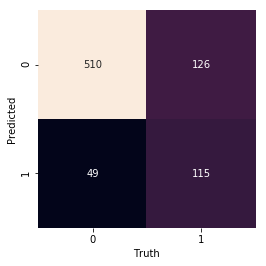

In [78]:
# Confusion matrix of trained model on training set

matrix = confusion_matrix(y_pred_train_mlp, y_train)
values = np.unique(y_pred_train_mlp)

sns.heatmap(matrix, square=True, annot=True, fmt='d', cbar=False, xticklabels=values, yticklabels=values)
plt.xlabel('Truth')
plt.ylabel('Predicted')

# RESULTS
# 629 are correct, 28 of Type 1 error (false positive), 143 of Type 2 error (false negative)


Text(91.68, 0.5, 'Predicted')

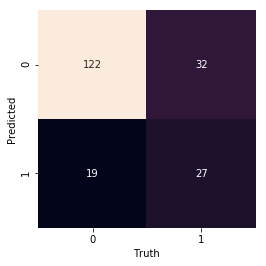

In [79]:
# Confusion matrix of trained model on testing set

matrix = confusion_matrix(y_pred_test_mlp, y_test)
values = np.unique(y_pred_test_mlp)

sns.heatmap(matrix, square=True, annot=True, fmt='d', cbar=False, xticklabels=values, yticklabels=values)
plt.xlabel('Truth')
plt.ylabel('Predicted')

# RESULTS
# 153 are correct, 15 of Type 1 error (false positive), 32 of Type 2 error (false negative)


In [80]:
# POSSIBLE REASONS FOR 75-80% ACCURACY
# Missing data values for some Savings and Checking entries
# Incomplete data set: Income, Number of People in Household
# Some features less important than others: Purpose
# 1000 entries, not as large of a data set

In [81]:
# RESOURCES
# https://towardsdatascience.com/solving-a-simple-classification-problem-with-python-fruits-lovers-edition-d20ab6b071d2
# https://www.kaggle.com/coolman/different-classification-techniques-python
# https://datascience.stackexchange.com/questions/28426/train-accuracy-vs-test-accuracy-vs-confusion-matrix
# https://machinelearningmastery.com/make-predictions-scikit-learn/
